In [1]:
import matplotlib.pyplot as plt
from wavebench.dataloaders.rtc_loader import get_dataloaders_rtc_thick_lines, get_dataloaders_rtc_mnist
from wavebench.dataloaders.is_loader import get_dataloaders_is_thick_lines, get_dataloaders_is_mnist
from wavebench import wavebench_figure_path
import matplotlib.colors as colors

import wandb
from wavebench.nn.pl_model_wrapper import LitModel
from pathlib import Path
from wavebench import wavebench_checkpoint_path
from wavebench.plot_utils import plot_images, remove_frame

from pytorch_lightning.loggers import WandbLogger
import ml_collections
import torch
import pprint


# Initialize the W&B API client
api = wandb.Api()


pp = pprint.PrettyPrinter(depth=6)
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

eval_config = ml_collections.ConfigDict()


# problem setting: can be 'is' or 'rtc'
# eval_config.problem = 'rtc'
eval_config.problem = 'is'

# dataset setting: can be 'thick_lines' or 'mnist'
# eval_config.dataset_name = 'mnist'
# eval_config.dataset_name = 'thick_lines'

# medium_type setting: can be 'gaussian_lens' or 'gaussian_random_field'
eval_config.medium_type = 'gaussian_lens'
# eval_config.medium_type = 'gaussian_random_field'


if eval_config.problem == 'rtc':
  in_dist_test_loader = get_dataloaders_rtc_thick_lines(
    medium_type=eval_config.medium_type,
    use_ffcv=False,
  )['test']
  ood_test_loader = get_dataloaders_rtc_mnist(
    medium_type=eval_config.medium_type,
    use_ffcv=False,
  )

elif eval_config.problem == 'is':
  in_dist_test_loader = get_dataloaders_is_thick_lines(
    medium_type=eval_config.medium_type,
    use_ffcv=False,
  )['test']
  ood_test_loader = get_dataloaders_is_mnist(
    medium_type=eval_config.medium_type,
    use_ffcv=False,
    )


### Visualize dataset

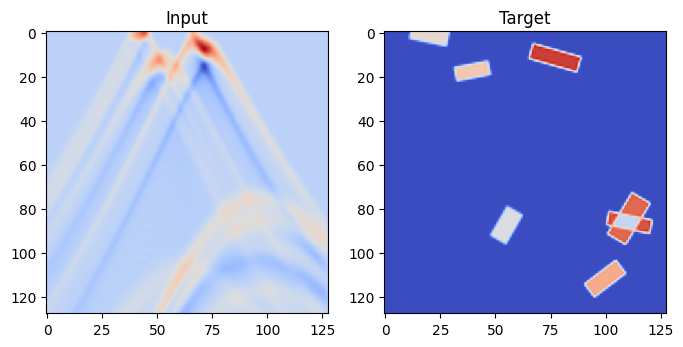

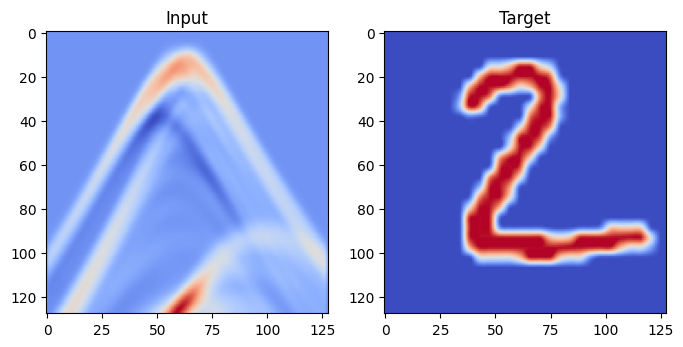

In [2]:
idx = 1
sample_input, sample_target = in_dist_test_loader.dataset.__getitem__(idx)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].imshow(sample_input.squeeze().numpy(), cmap='coolwarm')
axes[0].set_title('Input')
axes[1].imshow(sample_target.squeeze().numpy(), cmap='coolwarm')
axes[1].set_title('Target')

plt.show()

idx = 1
sample_input, sample_target = ood_test_loader.dataset.__getitem__(idx)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].imshow(sample_input.squeeze().numpy(), cmap='coolwarm')
axes[0].set_title('Input')
axes[1].imshow(sample_target.squeeze().numpy(), cmap='coolwarm')
axes[1].set_title('Target')

plt.show()

# axes[2].imshow(pred.squeeze().numpy(), cmap='coolwarm')
# axes[2].set_title('Prediction')
# rtc_loaders[medium_type] = loaders

### Load relevant models

In [3]:

all_models = [
  {
    "tag": 'fno-depth-4',
    "config.model_config/model_name": 'fno',
    "config.model_config/num_hidden_layers": 4
  },
  {
    "tag": 'fno-depth-8',
    "config.model_config/model_name": 'fno',
    "config.model_config/num_hidden_layers": 8
  },
  {
    "tag": 'unet-ch-32',
    "config.model_config/model_name": 'unet',
    "config.model_config/channel_reduction_factor": 2
  },
  {
    "tag": 'unet-ch-64',
    "config.model_config/model_name": 'unet',
    "config.model_config/channel_reduction_factor": 1
  },

              ]




1
checkpoint: tliu/is_gaussian_lens/model-lh37r7q0:best
kept model-lh37r7q0:v8, ['best', 'latest']


wandb: Downloading large artifact model-lh37r7q0:best, 192.42MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.9


model hparams:
{'hidden_width': 64,
 'model_name': 'fno',
 'modes1': 16,
 'modes2': 16,
 'num_hidden_layers': 4,
 'num_in_channels': 1,
 'num_out_channels': 1}
1
checkpoint: tliu/is_gaussian_lens/model-ie4da06c:best
kept model-ie4da06c:v6, ['best', 'latest']


wandb: Downloading large artifact model-ie4da06c:best, 384.63MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.8


model hparams:
{'hidden_width': 64,
 'model_name': 'fno',
 'modes1': 16,
 'modes2': 16,
 'num_hidden_layers': 8,
 'num_in_channels': 1,
 'num_out_channels': 1}
1
checkpoint: tliu/is_gaussian_lens/model-o12ysm01:best
kept model-o12ysm01:v18, ['best', 'latest']


wandb: Downloading large artifact model-o12ysm01:best, 88.95MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.8


model hparams:
{'channel_reduction_factor': 2,
 'model_name': 'unet',
 'n_input_channels': 1,
 'n_output_channels': 1}
1
checkpoint: tliu/is_gaussian_lens/model-kj3ilzea:best
kept model-kj3ilzea:v23, ['latest', 'best']


wandb: Downloading large artifact model-kj3ilzea:best, 355.33MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.6


model hparams:
{'channel_reduction_factor': 1,
 'model_name': 'unet',
 'n_input_channels': 1,
 'n_output_channels': 1}


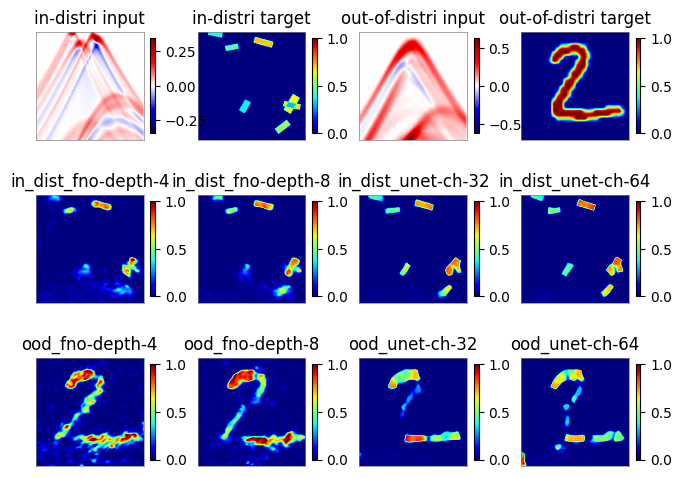

In [51]:
model_dict = {}

for model_filters in all_models:
  _model_filters = model_filters.copy()

  model_tag = _model_filters.pop('tag')

  project = f'{eval_config.problem}_{eval_config.medium_type}'
  runs = api.runs(
    path=f"tliu/{project}",
    filters=_model_filters)

  # make sure that there is a unique model that satisfies the filters
  print(len(runs))
  assert len(runs) == 1

  run_id = runs[0].id

  checkpoint_reference = f"tliu/{project}/model-{run_id}:best"#best"
  print(f'checkpoint: {checkpoint_reference}')

  # delete all the checkpoints that do not have aliases
  artifact_versions = api.artifact_versions(
    name=f'{project}/model-{run_id}', type_name='model')

  for v in artifact_versions:
    if len(v.aliases) == 0:
      v.delete()
      print(f'deleted {v.name}')
    else:
      print(f'kept {v.name}, {v.aliases}')

  artifact_dir = WandbLogger.download_artifact(
    artifact=checkpoint_reference,
    save_dir=wavebench_checkpoint_path)

  # load checkpoint
  model = LitModel.load_from_checkpoint(
    Path(artifact_dir) / "model.ckpt").to(device)

  print('model hparams:')
  pp.pprint(model.hparams.model_config)

  model_dict[model_tag] = model
  # runs = api.runs(path="tliu/rtc_gaussian_lens")

idx = 1
in_dist_sample_input, in_dist_sample_target = in_dist_test_loader.dataset.__getitem__(idx)
ood_sample_input, ood_sample_target = ood_test_loader.dataset.__getitem__(idx)

pannel_dict = {
  'in-distri input': in_dist_sample_input.squeeze(),
  'in-distri target': in_dist_sample_target.squeeze(),
  'out-of-distri input': ood_sample_input.squeeze(),
  'out-of-distri target': ood_sample_target.squeeze(),
}

for setting in ['in_dist', 'ood']:
  if setting == 'in_dist':
    sample_input = in_dist_sample_input
  else:
    sample_input = ood_sample_input
  for tag, model in model_dict.items():
    pred = model(sample_input.unsqueeze(0).to(device)).detach().cpu().squeeze()
    pannel_dict[f'{setting}_{tag}'] = pred


nrows = 3
ncols = 4
fig_size = (8, 6)
cbar_shrink = 0.7
x_list = list(pannel_dict.values())
for i in range(len(x_list)):
    x_list[i] = np.asarray(x_list[i])


import numpy as np
from wavebench.plot_utils import plot_image

fig = plt.figure()
fig.set_size_inches(fig_size)
axes = fig.subplots(nrows, ncols)
im = np.empty(axes.shape, dtype=object)



for i, (x, ax_, v) in enumerate(zip(x_list, axes.flat, vrange_)):
    if i ==0 or i == 2:
        im_, _ = plot_image(x, ax=ax_, norm=colors.CenteredNorm(), cmap='seismic')
    else:
        im_, _ = plot_image(x, ax=ax_, vmin=0., vmax=1., cmap='jet')
    im.flat[i] = im_
    fig.colorbar(im_, ax=ax_, shrink=cbar_shrink)


for i, ax in enumerate(axes.flatten()):
  ax.set_title( list(pannel_dict.keys()) [i])
  remove_ticks(ax)

In [23]:
import matplotlib as mpl
# set the colormap and centre the colorbar
class MidpointNormalize(mpl.colors.Normalize):
    """Normalise the colorbar."""
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

Text(0.5, 1.0, 'Problem: is, Wavespeed: gaussian_lens')

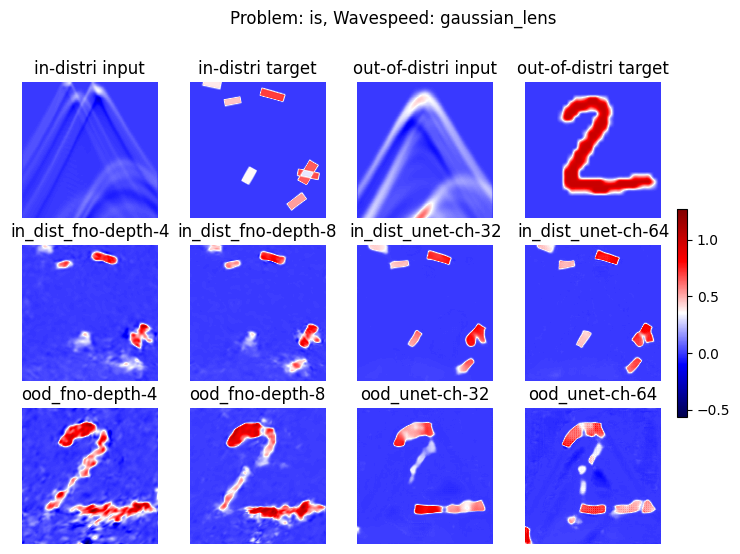

In [25]:
fig, axes = plot_images(
  list(pannel_dict.values()),
  nrows=3,
  # cbar='many',
  fig_size=(10, 6),
  shrink=0.45,
  pad=0.02,
  cmap='seismic',
  # vrange=(-0.5, 0.5)
  # norm=MidpointNormalize(-0.5, 1.5, 0.)
  )

# axes[0,0]
for i, ax in enumerate(axes.flatten()):
  ax.set_title( list(pannel_dict.keys()) [i])
  remove_frame(ax)

plt.suptitle(
  f'Problem: {eval_config.problem}, Wavespeed: {eval_config.medium_type}',
  y=1.0,)


In [5]:

# plt.savefig(
#   f"{wavebench_figure_path}/model_out_{eval_config.problem}_{eval_config.dataset_name}_{eval_config.medium_type}.pdf",
#   format="pdf", bbox_inches="tight")


In [48]:
from wavebench.plot_utils import remove_ticks

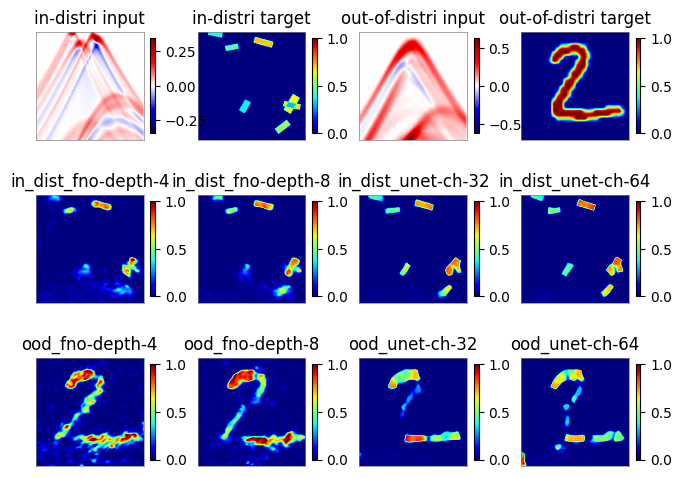

In [50]:
nrows = 3
ncols = 4
fig_size = (8, 6)
cbar_shrink = 0.7
x_list = list(pannel_dict.values())
for i in range(len(x_list)):
    x_list[i] = np.asarray(x_list[i])


import numpy as np
from wavebench.plot_utils import plot_image

fig = plt.figure()
fig.set_size_inches(fig_size)
axes = fig.subplots(nrows, ncols)
im = np.empty(axes.shape, dtype=object)



for i, (x, ax_, v) in enumerate(zip(x_list, axes.flat, vrange_)):
    if i ==0 or i == 2:
        im_, _ = plot_image(x, ax=ax_, norm=colors.CenteredNorm(), cmap='seismic')
    else:
        im_, _ = plot_image(x, ax=ax_, vmin=0., vmax=1., cmap='jet')
    im.flat[i] = im_
    fig.colorbar(im_, ax=ax_, shrink=cbar_shrink)


for i, ax in enumerate(axes.flatten()):
  ax.set_title( list(pannel_dict.keys()) [i])
  remove_ticks(ax)
